In [151]:
import tensorflow as tf
import tensorlayer as tl
from pymoo.core.algorithm import Algorithm
from pymoo.operators.sampling.rnd import FloatRandomSampling
from torch.distributions import Normal, Uniform
from pymoo.core.initialization import Initialization
from pymoo.algorithms.moo.nsga2 import RankAndCrowdingSurvival
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.core.population import Population
from pymoo.operators.repair.bounds_repair import is_out_of_bounds_by_problem
from pymoo.core.repair import NoRepair
from torch import optim
import torch
import numpy as np
from pymoo.util.optimum import filter_optimum
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
import matplotlib.pyplot as plt
import numpy as np
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination import get_termination
from random import randint
from pymoo.constraints.as_obj import ConstraintsAsObjective
from pymoo.termination.ftol import SingleObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination
from pymoo.termination.default import DefaultMultiObjectiveTermination
import random
import os



In [169]:
class Deep_Deterministic_policy_gradient(Algorithm):
    def __init__(self,
                 gamma=0.99,
                 actor_alpha=0.01,
                 critic_alpha=0.01,
                 num_rounds=20,
                 sampling=FloatRandomSampling(),
                 repair=NoRepair(),
                 memory_capacity=1000,
                 step_size = 0.1,
                 var = 2,
                 **kwargs):
        super().__init__(**kwargs)
        self.actor_alpha = actor_alpha
        self.critic_alpha = critic_alpha
        self.gamma = gamma
        self.var = var
        self.memory_capacity = memory_capacity
        self.pointer = 0
        self.rewards = []
        self.steps_taken = []
        self.step_size = step_size
        self.W_init = tf.random_normal_initializer(mean=0, stddev=0.3)
        self.b_init = tf.constant_initializer(0.1)
        self.initialization = Initialization(sampling)
        self.survival = RankAndCrowdingSurvival()
        self.crossover = SimulatedBinaryCrossover(n_offsprings=1)
        self.num_rounds = num_rounds
        self.repair = repair

        
    def get_actor(self,input_state_shape, name=''):
        tl.layers.set_name_reuse(True)
        input_layer = tl.layers.Input(input_state_shape, name='A_input')
        layer = tl.layers.Dense(n_units=self.n_var, act=tf.nn.relu, W_init=self.W_init, b_init=self.b_init, name='A_l1')(input_layer)
        #print("layer1",layer)
        layer = tl.layers.Dense(n_units=self.n_var, act=tf.nn.relu, W_init=self.W_init, b_init=self.b_init, name='A_l2')(layer)
        #print("layer2",layer)
        layer = tl.layers.Dense(n_units=self.n_var, act=tf.nn.tanh, W_init=self.W_init, b_init=self.b_init, name='A_a')(layer)
        #print("layer3",layer)
        #layer = tl.layers.Lambda(lambda x: self.step_size * (x+1)-self.step_size)(layer)
        #print("layer4",layer)            
        return tl.models.Model(inputs=input_layer, outputs=layer)
            
    def get_critic(self,input_state_shape, input_action_shape, name=''):
        tl.layers.set_name_reuse(True)
        s = tl.layers.Input(input_state_shape, name='C_s_input')
        a = tl.layers.Input(input_action_shape, name='C_a_input')
        x = tl.layers.Concat(1)([s, a])
        x = tl.layers.Dense(n_units=self.n_var, act=tf.nn.relu, W_init=self.W_init, b_init=self.b_init, name='C_l1')(x)
        x = tl.layers.Dense(n_units=self.n_var, act=tf.nn.relu, W_init=self.W_init, b_init=self.b_init, name='C_l2')(x)
        x = tl.layers.Dense(n_units=1, W_init=self.W_init, b_init=self.b_init, name='C_out')(x)
        return tl.models.Model(inputs=[s, a], outputs=x)
            
        

    def copy_para(self,from_model, to_model):
        for i, j in zip(from_model.trainable_weights, to_model.trainable_weights):
            j.assign(i)
        
        

    def ema_update(self):
        paras = self.actor.trainable_weights + self.critic.trainable_weights    
        self.ema.apply(paras)                                               
        for i, j in zip(self.actor_target.trainable_weights + self.critic_target.trainable_weights, paras):
            i.assign(self.ema.average(j))

    def choose_action(self, s):
        return self.actor(np.array([s], dtype=np.float32))[0]
        
    def learn(self):
        #print("Learning")
        indices = np.random.choice(self.memory_capacity, size=64)    
        bt = self.memory[indices, :]                    
        bs = bt[:, :self.s_dim]                        
        ba = bt[:, self.s_dim:self.s_dim + self.n_var]  
        br = bt[:, -self.s_dim - 1:-self.s_dim]        
        bs_ = bt[:, -self.s_dim:]                     


        with tf.GradientTape() as tape:
            a_ = self.actor_target(bs_)
            q_ = self.critic_target([bs_, a_])
            y = br + self.gamma * q_
            q = self.critic([bs, ba])
            td_error = tf.losses.mean_squared_error(y, q)
        c_grads = tape.gradient(td_error, self.critic.trainable_weights)
        self.critic_opt.apply_gradients(zip(c_grads, self.critic.trainable_weights))
        self.ema_update()

    def store_transition(self, s, a, r, s_):
        
        s = s.astype(np.float32)
        s_ = s_.astype(np.float32)

        transition = np.hstack((s, a, r, s_))

        index = self.pointer % self.memory_capacity
        self.memory[index, :] = transition
        self.pointer += 1
    
    def save(self):
        """
        save trained weights
        :return: None
        """
        path = os.path.join('model', '_'.join(['DDPG', 'Pendulum-v0']))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'actor.hdf5'), self.actor)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'actor_target.hdf5'), self.actor_target)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'critic.hdf5'), self.critic)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'critic_target.hdf5'), self.critic_target)
    
    def load(self):
        """
        load trained weights
        :return: None
        """
        path = os.path.join('model', '_'.join(['DDPG', 'Pendulum-v0']))
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'actor.hdf5'), self.actor)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'actor_target.hdf5'), self.actor_target)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'critic.hdf5'), self.critic)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'critic_target.hdf5'), self.critic_target)

    def _setup(self, problem, **kwargs):
        self.n_var = np.array(self.problem.n_var)
        self.s_dim = self.n_var
        self.bound = np.array(self.problem.bounds())
        self.memory = np.zeros((self.memory_capacity, self.s_dim * 2 + self.n_var + 1), dtype=np.float32)
        self.mean = self.problem.xl + (self.problem.xu - self.problem.xl)/2
        self.std = np.sqrt(((self.problem.xu - self.problem.xl)**2)/12)

        self.actor = self.get_actor([None, self.s_dim])
        self.critic = self.get_critic([None, self.s_dim], [None, self.n_var])
        self.actor.train()
        self.critic.train()
        self.actor_target = self.get_actor([None, self.s_dim], name='_target')
        self.copy_para(self.actor, self.actor_target)
        self.actor_target.eval()

        self.critic_target = self.get_critic([None, self.s_dim], [None, self.n_var], name='_target')
        self.copy_para(self.critic, self.critic_target)
        self.critic_target.eval()

        self.R = tl.layers.Input([None, 1], tf.float32, 'r')

        self.ema = tf.train.ExponentialMovingAverage(decay=1 - 0.01)  # soft replacement

        self.actor_opt = tf.optimizers.Adam(self.actor_alpha)
        self.critic_opt = tf.optimizers.Adam(self.critic_alpha)
        
    def _initialize_infill(self):
        return self.initialization.do(self.problem, 1, algorithm=self)

    def _initialize_advance(self, infills=None, **kwargs):
        self.data_set_X = self.pop.get("X")
        #super()._initialize_advance(infills=infills, **kwargs)

    def _infill(self):
        state = self.get_starting_point()
        normalized_state = self.custom_state_normalization(state)
        termination_rounds = self.num_rounds 
        steps = 0
        ep_reward = 0

        while steps < termination_rounds:
            #print("self.opt.get(F)",self.opt.get("F"))
           # print("self.problem.evaluate(np.array(state))[0]",self.problem.evaluate(np.array(state))[0])
            #print("state",state)
            a = self.choose_action(np.array(normalized_state))
            a = np.clip(np.random.normal(a, self.var), -1, 1)
            action_vector = self.step_size * (a + 1) - self.step_size
            new_state, reward = self.step(action_vector,state)
            self.store_transition(normalized_state, a, reward / 10, new_state)
            if self.pointer > self.memory_capacity:
                self.learn()
            state = new_state
            normalized_state = self.custom_state_normalization(new_state)
            ep_reward += reward
            steps +=1

        #print("normalized_state2",normalized_state)
        
        self.rewards.append(ep_reward)
        self.steps_taken.append(steps)
        print("Episode: {} --- Rewards: {} --- Steps: {}".format(self.n_iter, ep_reward, steps))
        return self.pop
        
    def _advance(self, infills=None, **kwargs):
        #print(self.pop.get("F"))
        #print(self.opt.get("F"))
        return super()._advance(infills=infills, **kwargs)
    
    
    def _finalize(self):
        state_list = []
        for episode in range(200):
            state = self.get_starting_point()
            episode_reward = 0
            for step in range(20):
                a = self.choose_action(np.array(state))
                action_vector = self.step_size * (a + 1) - self.step_size
                #print("action_vector",action_vector)
                #print("state",state)
                state, reward = self.step(np.array(action_vector), state)
                episode_reward += reward
                state_list.append(self.problem.evaluate(state, return_values_of=["F"]))   
            print("Episode: {} --- Rewards: {} --- Steps: {}".format(episode, episode_reward, 20))
        
        print("final_X:", state)
        print("final_F:", np.min(state_list))
        return super()._finalize()
    
    def get_rewards(self, current_state, new_state):
        #print("current_state",current_state)
        #print("new_state",new_state)
        is_infesible = False
        current_state_value = self.problem.evaluate(current_state, return_values_of=["F"])
        new_state_value = self.problem.evaluate(new_state, return_values_of=["F"])
        diff = new_state_value - current_state_value
        eucli_dist = self.euclidean_distance(current_state_value,new_state_value)
        c1, c2, c3, c4, c5, c6 = 10, 1, -1, -3, -3, -1
        #print("eucli_dist:",eucli_dist)
        #print("self.problem.evaluate(new_state)[0]",self.problem.evaluate(new_state)[0])
        #print("self.problem.evaluate(current_state)[0]",self.problem.evaluate(current_state)[0])
        domain_penalty = self.domain_penalty_function(new_state)
        constraint_penalty = self.constraint_penalty_function(new_state)
        if domain_penalty > 0 or constraint_penalty > 0:
            #print("domain_penalty",domain_penalty)
            #print("constraint_penalty",constraint_penalty)
            is_infesible = True
            #print("infesible:",domain_penalty,constraint_penalty)
            return c5*eucli_dist + c6*(domain_penalty + constraint_penalty), is_infesible
        elif np.all(diff <= 0):
            #print("c1:",diff)
            self.data_set_X = np.vstack((self.data_set_X, new_state))
            #print("self.data_set_X",self.data_set_X)
            off = Population.new(X=self.data_set_X, F = self.problem.evaluate(self.data_set_X, return_values_of=["F"]))
            self.pop = off
            return c1*eucli_dist, is_infesible
        elif np.all(diff >= 0):
            #print("c4:",diff)
            return c4*eucli_dist, is_infesible
        elif np.all(diff == 0):
            #print("c3:",diff)
            return c3, is_infesible
        else:
            #print("c2:",diff)
            return c2*eucli_dist, is_infesible
    
    def domain_penalty_function(self, state):
        return  np.sum(np.maximum(0, state - self.problem.xu)**2) + np.sum(np.maximum(0, self.problem.xl - state)**2)
    
    def constraint_penalty_function(self, state):
        return np.sum(np.maximum(0, self.problem.evaluate(state, return_values_of=["G"]))**2) + np.sum(np.maximum(0, self.problem.evaluate(state, return_values_of=["H"]))**2)
    
    def get_starting_point(self):
        if self.pop.size <= 2 or np.random.random_sample() > 0.5:
            return self.initialization.do(self.problem, 1, algorithm=self).get("X")[0]
            while self.constraint_penalty_function(point) > 0:
                point = self.initialization.do(self.problem, 1, algorithm=self).get("X")[0]
            #print("point",point, self.constraint_penalty_function(point))
            print("n_point",point, self.custom_state_normalization(point))
            #return point
            #return self.initialization.do(self.problem, 1, algorithm=self).get("X")[0]
        else:
            new_parents = self.survival.do(self.problem, self.pop, n_survive=2)
            new_state = self.crossover.do(self.problem, [new_parents]).get("X")[0]
            return new_state
    
    def state_normalization(self, state):
        return (state - self.mean)/self.std
    
    def custom_state_normalization(self, state):
        max = self.problem.xu
        min = (self.problem.xl + self.problem.xu)/2
        return (state-min)/(max-min)
    
    def euclidean_distance(self, current_state_value, new_state_value):
        return np.sum((new_state_value - current_state_value)**2)**0.5

    def step(self, action, state):
        current_X = state
        X_new =  current_X + action
        #print("current_X:", current_X)
        #print("action:", action)
        #print("X_new:", X_new)
        reward, is_infesible = self.get_rewards(current_X, X_new)
        if is_infesible:
            return current_X, reward
        #while len(is_out_of_bounds_by_problem(self.problem, [X_new])) > 0:           
        #    X_new = self.sampling.do(self.problem, 1, algorithm=self).get("X")[0]
        
        
        
        #if self.is_constraint_model or self.problem.n_eq_constr > 0:
        #    Y_new = evlaution_of_new_points[0]
        #    Constraint_new = evlaution_of_new_points[1]
        #else:
        
        new_state = np.array(X_new)
        #print("rewards",reward)
        return new_state, reward




[TL] WARNING: this method is DEPRECATED and has no effect, please remove it from your code.
[TL] Input  A_input: [None, array(20)]
[TL] Dense  A_l1: 20 relu
[TL] Dense  A_l2: 20 relu
[TL] Dense  A_a: 20 tanh
[TL] WARNING: this method is DEPRECATED and has no effect, please remove it from your code.
[TL] Input  C_s_input: [None, array(20)]
[TL] Input  C_a_input: [None, array(20)]
[TL] Concat concat_179: concat_dim: 1
[TL] Dense  C_l1: 20 relu
[TL] Dense  C_l2: 20 relu
[TL] Dense  C_out: 1 No Activation
[TL] WARNING: this method is DEPRECATED and has no effect, please remove it from your code.
[TL] Input  A_input: [None, array(20)]
[TL] Dense  A_l1: 20 relu
[TL] Dense  A_l2: 20 relu
[TL] Dense  A_a: 20 tanh
[TL] WARNING: this method is DEPRECATED and has no effect, please remove it from your code.
[TL] Input  C_s_input: [None, array(20)]
[TL] Input  C_a_input: [None, array(20)]
[TL] Concat concat_180: concat_dim: 1
[TL] Dense  C_l1: 20 relu
[TL] Dense  C_l2: 20 relu
[TL] Dense  C_out: 1 

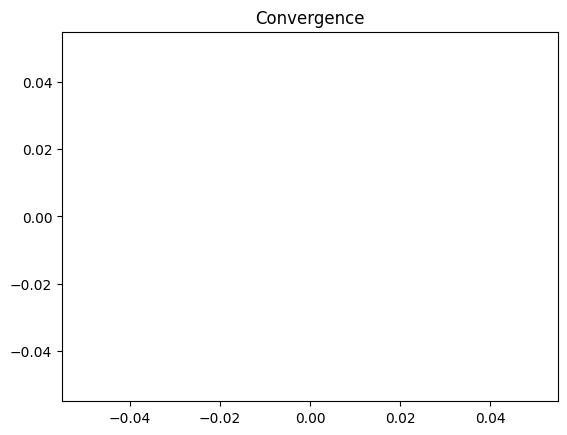

In [171]:

tf.random.set_seed (2)

problem = get_problem("ackley", n_var=20, a=20, b=1/5, c=2 * np.pi)
problem1 = get_problem("Rastrigin", n_var=20)
problem2 = get_problem("Rosenbrock", n_var=20)
problem3 = get_problem("g6")
problem4 = get_problem("dtlz3")
algorithm3 = Deep_Deterministic_policy_gradient(step_size= 0.01, var=1,num_rounds=20)
res = minimize( problem2,
                algorithm3,
                save_history=False,
                termination=('n_iter', 200),
                seed = 2,
                return_least_infeasible=True,
                verbose=True)

pf = problem2.pareto_front()
print("PF",pf[0])
ind = GD(pf)
print("GD", ind(res.F))
ind2 = IGD(pf)
print("IGD", ind2(res.F))


n_evals = np.array([e.evaluator.n_eval for e in res.history])

opt = np.array([e.opt[0].F for e in res.history])
print("final result X:",res.X)
print("final result F:",res.F)
print("final result CV:",res.CV)
print(opt)
plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.plot(n_evals, np.repeat(pf[0],len(n_evals)), 'k-', lw=1,dashes=[2, 2])
#plt.yscale("log")
plt.show() 

In [146]:
problem2.evaluate(res.X, return_values_of=["F", "H", "G"])


(array([3879.06268577]), array([], dtype=float64), array([], dtype=float64))

In [16]:
np.sum(np.maximum(0, res.X)) + np.sum(np.maximum(0, problem2.evaluate(res.X, return_values_of=["H"]))**2)

0.06462775510972782